In [1]:
# !unzip flood-area.zip -d flood-area

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_dir='flood-area'
print('No of images: ', len(os.listdir(os.path.join(base_dir,'Image'))))
print('No of masks: ',len(os.listdir(os.path.join(base_dir,'Mask'))))

No of images:  290
No of masks:  290


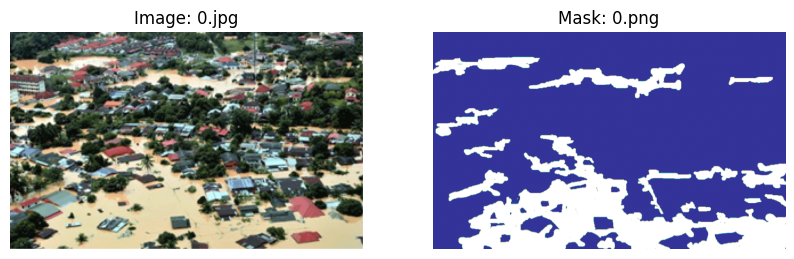

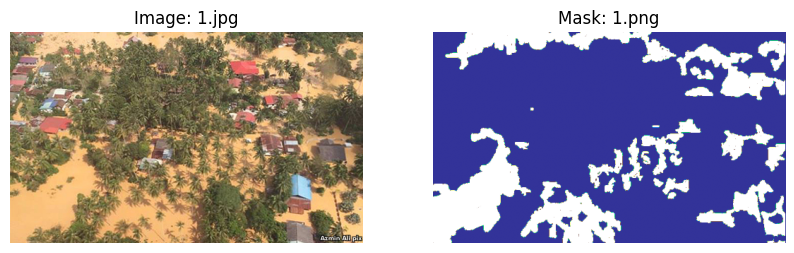

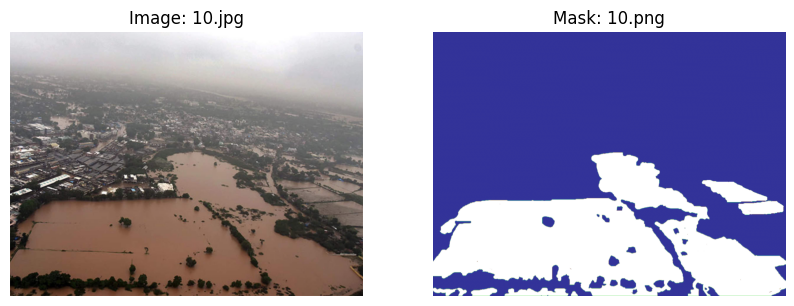

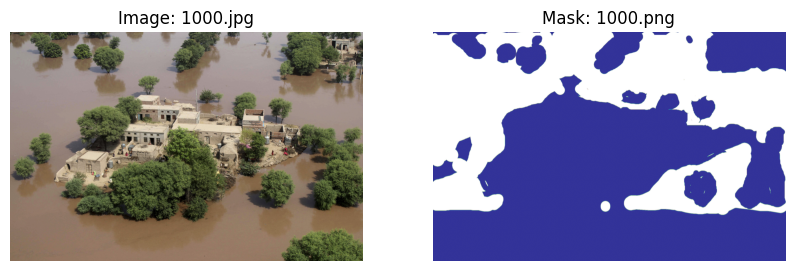

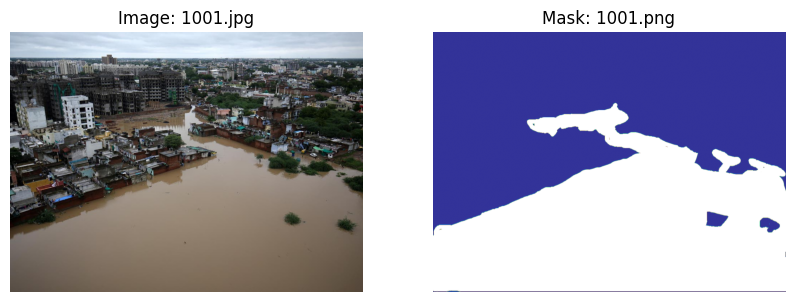

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_dir = os.path.join(base_dir, 'Image')
mask_dir = os.path.join(base_dir, 'Mask')

def visualize_images_and_masks(num_images=5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Image: {img_file}")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Mask: {mask_file}")
        plt.imshow(mask, cmap='terrain') # viridis
        plt.axis('off')

        plt.show()

# Call the function
visualize_images_and_masks()

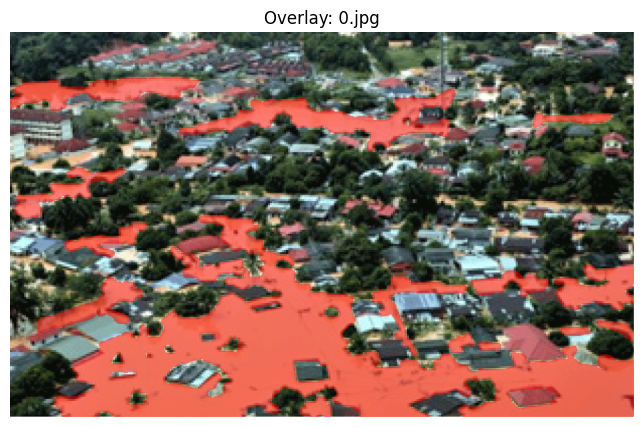

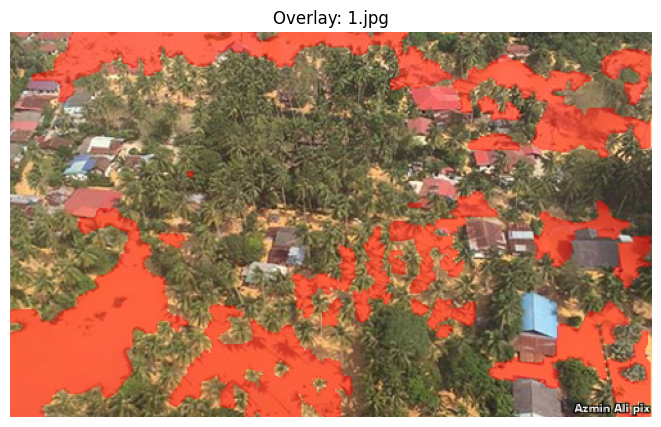

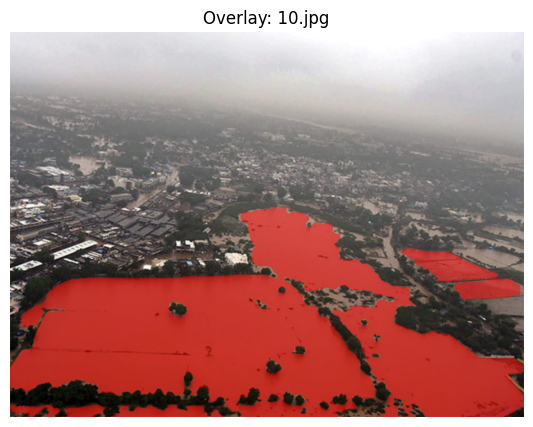

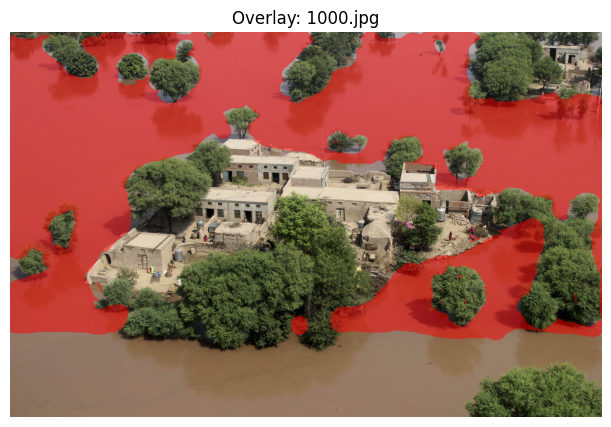

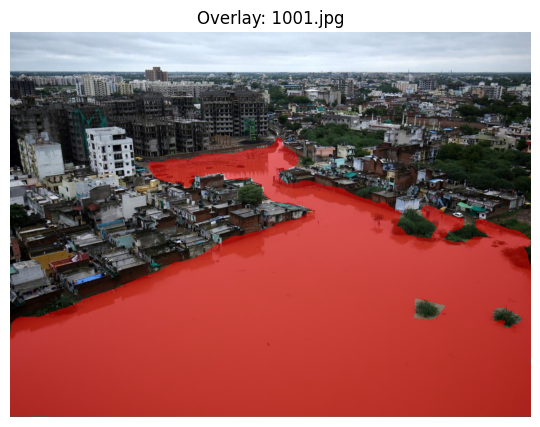

In [5]:
def overlay_mask_on_image(num_images=5, alpha=0.5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale # "L" stands for luminance, i.e., grayscale mode (1 channel, 0–255).
        # This is typically done because segmentation masks are not colorful pictures, but rather label maps — each pixel's intensity (or value) represents a class (e.g., 0 = background, 1 = object, etc.).
        # Grayscale is the most memory- and computation-efficient way to represent that.

        # | Conversion       | Mode                | Channels | Use Case                                      |
        # | ---------------- | ------------------- | -------- | --------------------------------------------- |
        # | `convert("L")`   | Grayscale           | 1        | Binary/multi-class masks as label maps        |
        # | `convert("RGB")` | RGB                 | 3        | Color-coded masks or visual overlays          |
        # | No convert       | Depends on original | As-is    | Use when you want to preserve original format |


        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red
        # Wherever the mask has a value > 0 (i.e., belongs to a region), it sets those pixels to red [255, 0, 0].

        blended = (1 - alpha) * img_np + alpha * overlay
        #Blends the red-highlighted overlay with the original image using alpha blending.

        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image()


# Segmentation

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

2025-06-01 21:49:56.305504: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 21:49:56.327815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 21:49:56.389326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748792996.468448   16512 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748792996.476175   16512 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748792996.574443   16512 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [7]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(f"Loaded {len(images)} images and masks.")


Loaded 290 images and masks.


In [8]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train.shape,X_val.shape

((232, 224, 224, 3), (58, 224, 224, 3))

In [9]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


E0000 00:00:1748793016.270306   16512 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748793016.271408   16512 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=BATCH_SIZE
)


Epoch 1/10


2025-06-01 21:50:26.303805: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.
2025-06-01 21:50:28.244711: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


1/8 ━━━━━━━━━━━━━━━━━━━━ 2:14 19s/step - accuracy: 0.5926 - loss: 0.6928

2025-06-01 21:50:38.354803: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.
2025-06-01 21:50:40.756142: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


2/8 ━━━━━━━━━━━━━━━━━━━━ 1:22 14s/step - accuracy: 0.5753 - loss: 0.6928

2025-06-01 21:50:52.983418: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


8/8 ━━━━━━━━━━━━━━━━━━━━ 110s 13s/step - accuracy: 0.5737 - loss: 0.6887 - val_accuracy: 0.5751 - val_loss: 0.6661
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 136s 12s/step - accuracy: 0.5616 - loss: 0.6421 - val_accuracy: 0.5758 - val_loss: 0.5811
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.5930 - loss: 0.6048 - val_accuracy: 0.6454 - val_loss: 0.5631
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - accuracy: 0.6644 - loss: 0.5749 - val_accuracy: 0.7101 - val_loss: 0.5458
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - accuracy: 0.7274 - loss: 0.5414 - val_accuracy: 0.7613 - val_loss: 0.5147
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 106s 13s/step - accuracy: 0.7660 - loss: 0.5045 - val_accuracy: 0.7934 - val_loss: 0.4196
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - accuracy: 0.7858 - loss: 0.4267 - val_accuracy: 0.8052 - val_loss: 0.3858
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 14s/step - accuracy: 0.7904 - loss: 0.4127 - val_accuracy: 0.8065 - val_loss: 0.3834
Epoch 9

In [11]:

# Save the trained model
model.save('model/unet_model.h5')

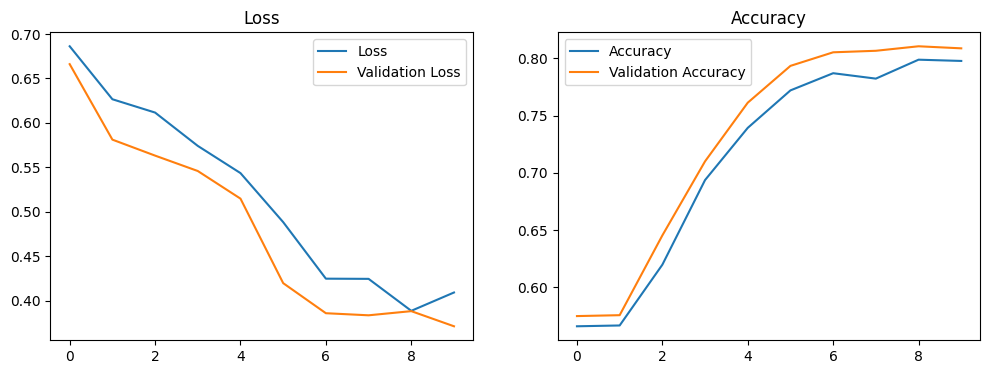

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


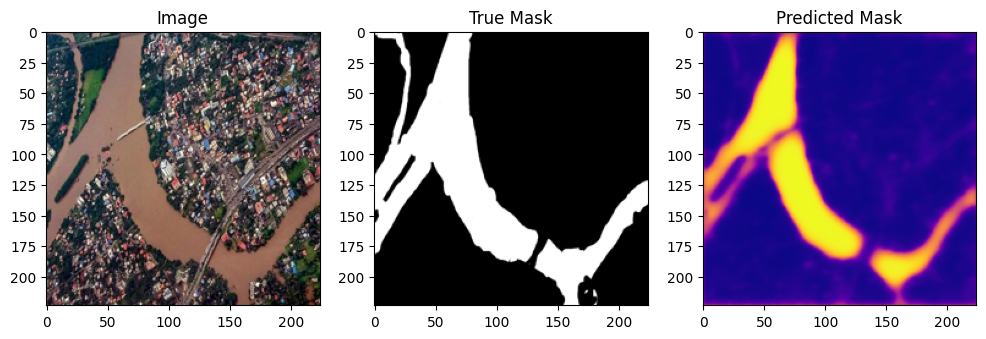

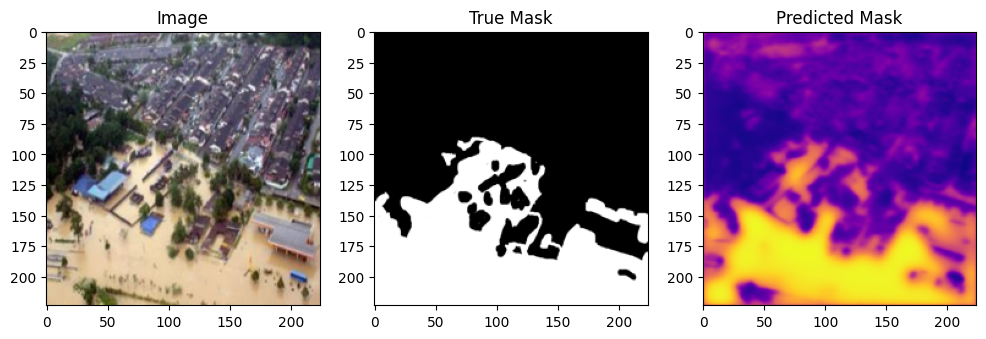

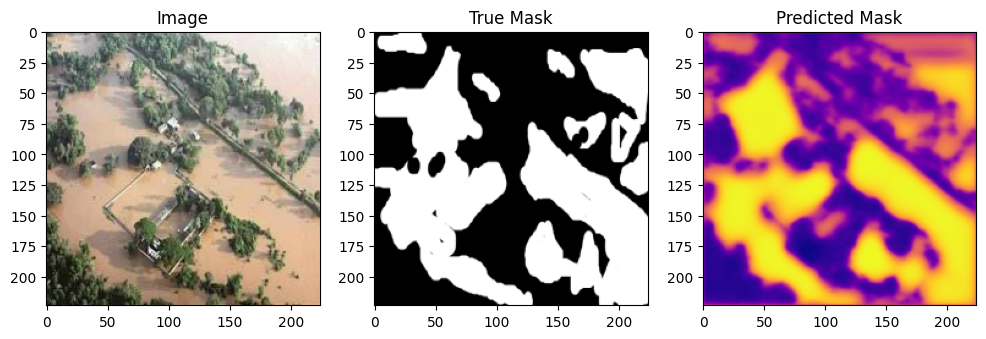

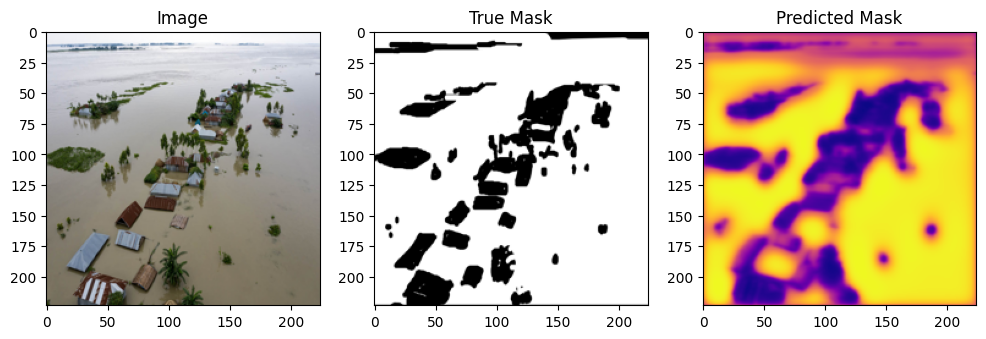

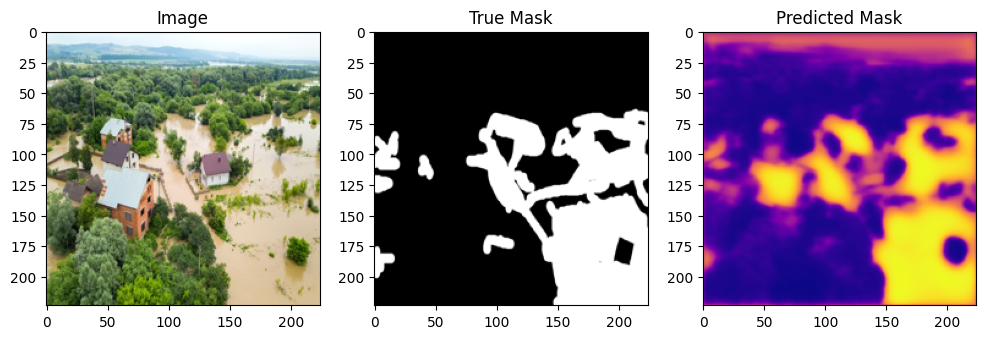

In [13]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='plasma') # gray

        plt.show()

visualize_predictions()


# Prediction on a single image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


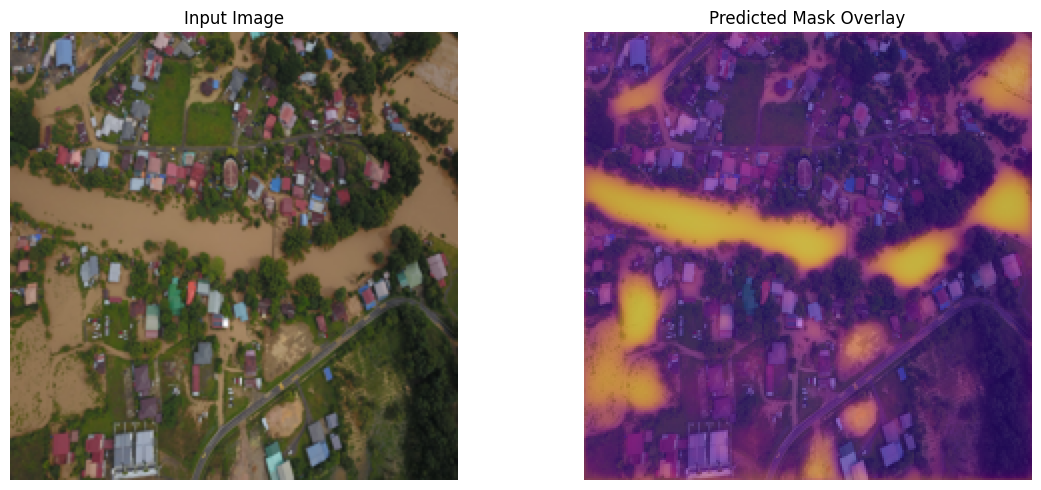

In [14]:
def visualize_prediction_from_path(img_path, alpha=0.5, cmap='plasma'):
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    img_np = np.array(img) / 255.0  # normalize to [0,1]

    pred = model.predict(np.expand_dims(img_np, axis=0))[0].squeeze()

    # Create colored overlay for predicted mask
    color_mask = plt.get_cmap(cmap)(pred)[:, :, :3]  # remove alpha channel
    # plt.get_cmap(cmap)(pred) applies the colormap (cmap, e.g., 'plasma') to the predicted mask array pred.
    # The colormap function returns an RGBA image — that is, a 4-channel image: Red, Green, Blue, and Alpha (transparency).
    # [:, :, :3] slices the array to keep only the first three channels (RGB) and remove the fourth channel (Alpha).
    
    overlay = (1 - alpha) * img_np + alpha * color_mask
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_prediction_from_path("flood-area/Image/7.jpg")

# Improvement suggestions by chatgpt


---

### 1. **Increase Model Capacity (More Filters and Depth)**

* Increase the number of filters at each layer to allow the model to learn more complex features.
* Add more encoding/decoding blocks (deeper U-Net) to capture more hierarchical information.

Example:

```python
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# similarly increase filters in deeper layers (128, 256, 512...)
```

---

### 2. **Use Batch Normalization**

* Add `BatchNormalization` after each convolution layer to stabilize and speed up training.

Example:

```python
from tensorflow.keras.layers import BatchNormalization

c1 = Conv2D(16, (3, 3), padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
```

---

### 3. **Use Dropout for Regularization**

* Add dropout layers in the bottleneck or decoder to reduce overfitting.

Example:

```python
from tensorflow.keras.layers import Dropout

c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
c4 = Dropout(0.5)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
```

---

### 4. **Use Advanced Activation Functions**

* Try using `LeakyReLU` or `ELU` instead of ReLU for better gradient flow.

Example:

```python
from tensorflow.keras.layers import LeakyReLU

c1 = Conv2D(16, (3, 3), padding='same')(inputs)
c1 = LeakyReLU(alpha=0.1)(c1)
```

---

### 5. **Use Residual or Dense Connections**

* Incorporate residual connections (like in ResNet) to ease training of deeper networks.

---

### 6. **Use Attention Mechanisms**

* Add attention gates (Attention U-Net) to help the network focus on important regions.

---

### 7. **Use Pretrained Encoders**

* Use pretrained backbones like `VGG`, `ResNet`, or `EfficientNet` for the encoder part. This helps if you have limited training data.

Libraries like `segmentation_models` make this easy:

```python
import segmentation_models as sm

model = sm.Unet('resnet34', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=1, activation='sigmoid')
```

---

### 8. **Use Dice Loss or Combined Loss**

* Use Dice loss or a combination of Dice + Binary Crossentropy loss to better handle class imbalance.

---

### 9. **Data Augmentation**

* Improve generalization by augmenting training images with rotations, flips, scaling, brightness changes, etc.

You can use `tf.keras.preprocessing.image.ImageDataGenerator` or `albumentations` for more advanced augmentation.

---

### 10. **Use Learning Rate Scheduling and Optimizers**

* Experiment with learning rate schedulers (`ReduceLROnPlateau`) or advanced optimizers like `AdamW` or `RAdam`.

---

### Summary Example (Improved block):

```python
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3,3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
```

Then replace your current conv blocks with this.

---

Would you like me to write an improved full U-Net model example incorporating some of these suggestions?
